# SeismoSense

The SeismoSense is a ML classifier project which predicts the alret level of an earthquake based on user-given inputs. The project serves through a Flask web app. 

In order to develop the perfect ML model for the project, we need to do lots of research and we also need to write the code somewhere else before putting it in the final script. This notebook is solely created for that purpose. It is used as a playground to test different hyperparameter settings as well as preprocessing approaches. 

## Importing the libraries

In [1]:
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,RandomizedSearchCV,learning_curve

# Models + SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Reading the dataset

In [2]:
df = pd.read_csv("dataset/earthquake_data.csv")

Printing out various information related to the data

In [3]:
df.head(5)

,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,green
1,6.9,25.0,4.0,4.0,-33.0,green
2,7.0,579.0,3.0,3.0,-13.0,green
3,7.3,37.0,5.0,5.0,65.0,green
4,6.6,624.0,0.0,2.0,-98.0,green


In [4]:
df.loc[df.alert == "orange", :].head(5)

,magnitude,depth,cdi,mmi,sig,alert
14,6.6,12.0,9.0,8.0,19.0,orange
35,6.6,13.0,9.0,8.0,-12.0,orange
61,7.3,10.0,9.0,9.0,1.0,orange
73,7.1,43.0,9.0,8.0,76.0,orange
79,7.0,21.0,8.0,7.0,-9.0,orange


In [5]:
df["alert"].value_counts()

alert
green     325
yellow    325
orange    325
red       325
Name: count, dtype: int64

Plotting correlational heatmap of the features

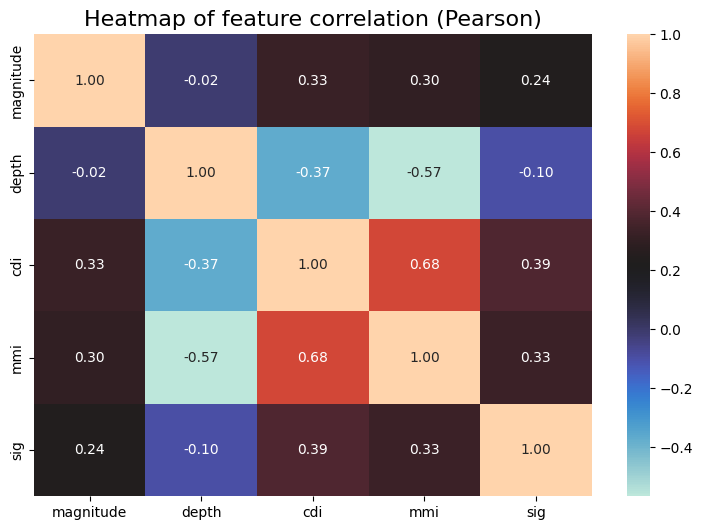

In [19]:
cor = df.iloc[:,:-1].corr()

plt.figure(figsize=(9,6))
sns.heatmap(cor,cmap="icefire",annot=True,fmt=".2f")
plt.title("Heatmap of feature correlation (Pearson)",fontdict={"fontsize":16})
plt.show()

### Key Takeaways
- **Strong Positive Correlation**: The strongest positive correlation is observed between cdi and mmi ($\text{r} = 0.68$).

- **Strong Negative Correlation**: The strongest negative correlation is between depth and mmi ($\text{r} = -0.57$), suggesting that as the depth increases, the Modified Mercalli Intensity tends to decrease.

- **Moderate Correlations**: Features like magnitude show moderate positive correlations with cdi ($\text{r} = 0.33$), mmi ($\text{r} = 0.30$), and sig ($\text{r} = 0.24$).

Saving the column names

In [6]:
column_names = df.columns

Feature and target column seperation

In [7]:
x = df.iloc[:,:-1].to_numpy()
y_unenc = df.iloc[:,-1]

Using LabelEncoder() to encode the class labels into integers

In [8]:
labelenc = LabelEncoder()
y = labelenc.fit_transform(y_unenc)

In [9]:
original_features = labelenc.classes_
encoded = range(len(original_features))
mapped = dict(zip(original_features,encoded))
print(mapped)

{'green': 0, 'orange': 1, 'red': 2, 'yellow': 3}


Train-test split

In [10]:
x_train,x_test,y_train,y_test = train_test_split(x,y,
 test_size=0.2,random_state=4,shuffle=True,stratify=y
)

Pipeline

In [11]:
xgb_model = xgb.XGBClassifier(random_state=91)
rf_model = RandomForestClassifier(random_state=92)
svc_model = SVC(random_state=3,)
knn_model = KNeighborsClassifier(p=2,metric="minkowski")
dtree = DecisionTreeClassifier(criterion="entropy",max_depth=4)
bagging_model = BaggingClassifier(estimator=dtree,random_state=192)

pipe = Pipeline([
  ("imputation", SimpleImputer(strategy="median")),
  ("scale", StandardScaler()),
  ("smote", SMOTE(random_state=84)),
  ("model", xgb_model)
])

Performing Randomized Search CV 

In [12]:
param_grid = [
  { # XGBoost
    "model":[xgb_model],"model__n_estimators":[500,700,1000,1200],
    "model__learning_rate":[0.01,0.1], "model__max_depth":np.arange(4,11,2)
  },
  { # Random Forest
    "model": [rf_model],"model__n_estimators":np.arange(600,1100,100),
    "model__max_depth": np.arange(5,11,2)
  },
  { # SVC
    "model":[svc_model],"model__kernel":["rbf"],"model__C":[0.01,0.1,1,10,100],
    "model__gamma":[0.01,0.1,1,10,100]
  },
  { # KNN
    "model":[knn_model],"model__n_neighbors":np.arange(3,6,1)
  },
  { # Bagging Classifier with Decision tree estimator
    "model":[bagging_model],"model__n_estimators":[500,700,1000]
  }
]

rscv = RandomizedSearchCV(
  estimator=pipe,param_distributions=param_grid,n_iter=12,
  n_jobs=-1,cv=10,random_state=53
)

rscv.fit(x_train,y_train)
estimator = rscv.best_estimator_
score = rscv.best_score_
config = rscv.best_params_

print(f"Best configuration:\n{config}")
print(f"Best score = {score}")

Best configuration:
{'model__n_estimators': 700, 'model__max_depth': np.int64(4), 'model__learning_rate': 0.1, 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)}
Best score = 0.9048076923076923


Printing the classification report

In [13]:
y_true = y_test
y_pred = rscv.predict(x_test)
print(classification_report(y_true=y_true,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86        65
           1       0.88      0.98      0.93        65
           2       0.98      0.94      0.96        65
           3       0.86      0.85      0.85        65

    accuracy                           0.90       260
   macro avg       0.90      0.90      0.90       260
weighted avg       0.90      0.90      0.90       260



Plotting the Learning Curve

In [14]:
train_size,train_scr,val_scr = learning_curve(estimator,x_train,y_train,
 train_sizes=np.linspace(0.1,1.0,10),cv=10,random_state=65,shuffle=True,n_jobs=-1
)

train_mean = np.mean(train_scr,axis=1)
val_mean = np.mean(val_scr,axis=1)
train_std = np.std(train_scr,axis=1)
val_std = np.std(val_scr,axis=1)

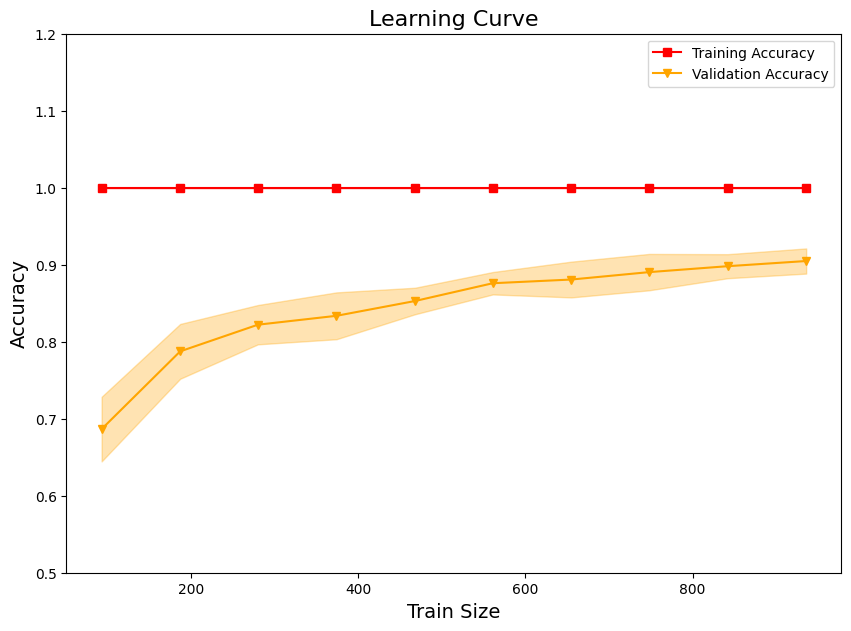

In [15]:
plt.figure(figsize=(10,7))
plt.plot(train_size,train_mean,color="red",label="Training Accuracy",marker="s")
plt.fill_between(
  train_size,train_mean + train_std, train_mean - train_std, color="red",alpha=0.3
)

plt.plot(train_size,val_mean,color="orange",label="Validation Accuracy",marker="v")
plt.fill_between(
  train_size,val_mean + val_std, val_mean - val_std, color="orange",alpha=0.3
)

plt.title("Learning Curve",fontdict={"fontsize":16})
plt.xlabel("Train Size",fontdict={"fontsize":14})
plt.ylabel("Accuracy",fontdict={"fontsize":14})
plt.ylim(0.5,1.2)
plt.legend()
plt.show()

### Key Takeaways
- **Training Accuracy is Perfect (1.0)**: The training accuracy is consistently $\mathbf{1.0}$ (or $\mathbf{100\%}$) across all training set sizes, suggesting the model has very high capacity and is overfitting the training data.
  
- **Validation Accuracy Improves Steadily**: The validation accuracy starts around $\mathbf{0.70}$ for small training sizes and gradually increases to about $\mathbf{0.92}$ as the training set size grows.

- **Moderate Variance/Bias**: The somewhat large gap between the Training Accuracy and the Validation Accuracy suggests the model suffers from moderate variance. Adding more data (increasing training size) helps reduce this gap slightly, but the training accuracy remains at $1.0$.